In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

In [88]:
moment = 1
obs = 'q'

## Set up observables

In [89]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = np.load('npfiles/rawdata.npz')
pT_true, pT_true_alt, pT_reco, pT_reco_alt, m_true, m_true_alt, m_reco, m_reco_alt, q_true, q_true_alt, q_reco, q_reco_alt = (datasets[datasets.files[i]] for i in range(12))

In [90]:
features = {}

features["m","rec","nom"] = m_reco
features["m","tru","nom"] = m_true
features["m","rec","alt"] = m_reco_alt
features["m","tru","alt"] = m_true_alt

features["q","rec","nom"] = q_reco
features["q","tru","nom"] = q_true
features["q","rec","alt"] = q_reco_alt
features["q","tru","alt"] = q_true_alt

maxvalues = {}

maxvalues['m'] = 200
maxvalues['w'] = 0.7
maxvalues['q'] = 0.5
maxvalues['r'] = 1

minvalues = {}

minvalues['m'] = 0
minvalues['w'] = 0
minvalues['q'] = -0.5
minvalues['r'] = 0

## Set up binning

In [91]:
#For the binning, make it so we have 50% in each bin growing from the low side
binvals = [100]
i = 0
while binvals[-1] < 500:
    for binhigh in range(binvals[i]+1,1000):
        purity = len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)*(pT_reco > binvals[i])*(pT_reco < binhigh)]) / len(pT_true[(pT_true > binvals[i])*(pT_true < binhigh)])
        if (purity > 0.5**0.5):
            i+=1
            binvals+=[binhigh]
            break

## IBU

In [92]:
def IBU(T,D,R,n):
    phis = [T]
    for i in range(n):
        m = R * phis[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + 10**-50)
        phis.append(np.dot(m.T, D))
    return phis[-1]

## Omnifold

In [93]:

import os
os.environ['CUDA_VISIBLE_DEVICES']="1"



from matplotlib import gridspec


#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [94]:
iterations = 5
dims = 2

In [95]:
weights_omnifold = np.load(f'npfiles/weights_omnifold_{obs}.npy')

In [96]:
binvalsObs = {}

binvalsObs[obs] = {}
pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1
xt = features[obs,"tru","nom"]
xr = features[obs,"rec","nom"]
for ii in range(len(binvals)-1):
    binvalsObs[obs][ii] = [minvalues[obs]]
    i = 0
    disttotal = 0.
    breakloop = True
    while len(binvalsObs[obs][ii]) < 15 and binvalsObs[obs][ii][-1] < maxvalues[obs] and breakloop:
        mycount = 0
        for binhigh in np.linspace(binvalsObs[obs][ii][i]+0.01,maxvalues[obs],100):
            mycount+=1
            purity = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xt[(pTbin_truth==ii)*(xt > binvalsObs[obs][ii][i])*(xt < binhigh)]))
            distamount = len(xt[(pTbin_reco==ii)*(pTbin_truth==ii)*(xr > binvalsObs[obs][ii][i])*(xr < binhigh)]) / (0.00000001+len(xr[(pTbin_reco==ii)*(pTbin_truth==ii)]))
            if (purity > 0.5):
                i+=1
                disttotal += distamount
                binvalsObs[obs][ii]+=[binhigh]
                #print("  ",binhigh,purity,disttotal,distamount)
                break
            if (mycount==99):
                breakloop = False
                #binvalsObs[obs][ii]+=[rmax]

    pass



In [97]:
#Next, let's construct the response matrix.

pTbin_truth = np.clip(np.digitize(pT_true,binvals),1,len(binvals)-1)-1
pTbin_reco = np.clip(np.digitize(pT_reco,binvals),1,len(binvals)-1)-1

xbin_truth_all = np.array([np.clip(np.digitize(xt,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
xbin_reco_all = np.array([np.clip(np.digitize(xr,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
xbin_truth_all = xbin_truth_all.T
xbin_reco_all = xbin_reco_all.T

xbin_truth = np.array([xbin_truth_all[i][pTbin_truth[i]] for i in range(len(pTbin_truth))])
xbin_reco = np.array([xbin_reco_all[i][pTbin_reco[i]] for i in range(len(pTbin_reco))])

###
bin2_truth = []
for i in range(len(pTbin_truth)):
    mybin = 0
    for i2 in range(0,pTbin_truth[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_truth+=[mybin+xbin_truth[i]]

bin2_reco = []
for i in range(len(pTbin_reco)):
    mybin = 0
    for i2 in range(0,pTbin_reco[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_reco+=[mybin+xbin_reco[i]]

#alt
xta = features[obs,"tru","alt"]
xra = features[obs,"rec","alt"]

pTbin_truth_alt = np.clip(np.digitize(pT_true_alt,binvals),1,len(binvals)-1)-1
pTbin_reco_alt = np.clip(np.digitize(pT_reco_alt,binvals),1,len(binvals)-1)-1

xbin_truth_all_alt = np.array([np.clip(np.digitize(xta,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)])
xbin_reco_all_alt = np.array([np.clip(np.digitize(xra,binvalsObs[obs][ii]),1,len(binvalsObs[obs][ii])-1)-1 for ii in range(len(binvals)-1)] )
xbin_truth_all_alt = xbin_truth_all_alt.T
xbin_reco_all_alt = xbin_reco_all_alt.T

xbin_truth_alt = np.array([xbin_truth_all_alt[i][pTbin_truth_alt[i]] for i in range(len(pTbin_truth_alt))])
xbin_reco_alt = np.array([xbin_reco_all_alt[i][pTbin_reco_alt[i]] for i in range(len(pTbin_reco_alt))])

bin2_truth_alt = []
for i in range(len(pTbin_truth_alt)):
    mybin = 0
    for i2 in range(0,pTbin_truth_alt[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_truth_alt+=[mybin+xbin_truth_alt[i]]

bin2_reco_alt = []
for i in range(len(pTbin_reco_alt)):
    mybin = 0
    for i2 in range(0,pTbin_reco_alt[i]):
        mybin+=len(binvalsObs[obs][i2])-1
    bin2_reco_alt+=[mybin+xbin_reco_alt[i]]

In [98]:
#IBU
H, xedges, yedges = np.histogram2d(bin2_truth,bin2_reco,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
H_alt, xedges, yedges = np.histogram2d(bin2_truth_alt,bin2_reco_alt,bins=[range(max(bin2_truth)+2),range(max(bin2_truth)+2)])
H_norm = H / H.sum(axis=1, keepdims=True)

T = np.sum(H,axis=1)
D = np.sum(H,axis=0)
D_alt = np.sum(H_alt,axis=0)
T_alt = np.sum(H_alt,axis=1)
ibu = IBU(T,D_alt,H_norm.T,10)

In [99]:
#Various corrections
means_binnedx = []
means_binnedx_alt = []
means_binnedx_alt_corrected = []
for i in range(7):

    mybin = 0
    for i2 in range(0,i):
        mybin += len(binvalsObs[obs][i2])-1

    ibu_i = [ibu[mybin+j] for j in range(len(binvalsObs[obs][i])-1)]

    x_centers = 0.5*(np.array(binvalsObs[obs][i][0:-1])+np.array(binvalsObs[obs][i][1:]))
    xvals = [len(xt[(pTbin_truth==i)*(xbin_truth==j)]) for j in range(len(binvalsObs[obs][i])-1)]
    xvals_alt = [len(xta[(pTbin_truth_alt==i)*(xbin_truth_alt==j)]) for j in range(len(binvalsObs[obs][i])-1)]
    means_binnedx += [np.sum(x_centers**moment*xvals)/np.sum(xvals)]
    means_binnedx_alt += [np.sum(x_centers**moment*ibu_i)/np.sum(ibu_i)]

    #Try a per-bin correction
    xiavg = []
    for j in range(len(binvalsObs[obs][i])-1):
        xiavg+=[np.mean(xt[(pTbin_truth==i)*(xbin_truth==j)]**moment)]
    xiavg = np.array(xiavg)
    means_binnedx_alt_corrected += [np.sum(xiavg*ibu_i)/np.sum(ibu_i)]

means_binnedx = np.array(means_binnedx)
means_binnedx_alt = np.array(means_binnedx_alt)
means_binnedx_alt_corrected = np.array(means_binnedx_alt_corrected)

In [100]:
#Unbinned

truth = np.array([np.mean(xt[pTbin_truth==i]**moment) for i in range(7)])

means_unbinnedx = np.array([np.mean(xt[pTbin_truth==i]**moment) for i in range(7)])
means_unbinnedx_alt = np.array([np.mean(xta[pTbin_truth_alt==i]**moment) for i in range(7)])

means_unbinnedx_reco = np.array([np.mean(xr[pTbin_reco==i]**moment) for i in range(7)])
means_unbinnedx_reco_alt = np.array([np.mean(xra[pTbin_reco_alt==i]**moment) for i in range(7)])
means_unbinnedx_omnifold_alt = np.array([np.average(xt[pTbin_truth==i]**moment,weights=weights_omnifold[-1,1][pTbin_truth==i]) for i in range(7)])

## Moment Unfolding

In [101]:
mom_unfold = np.load('npfiles/moment_unfolding_'+obs+'.npz')

In [102]:
truth = mom_unfold[f'x{moment}_t']
weighted_gen = mom_unfold[f'x{moment}_wg']

In [103]:
binvals = np.array(binvals)
binmid = (binvals[:-1] + binvals[1:])/2

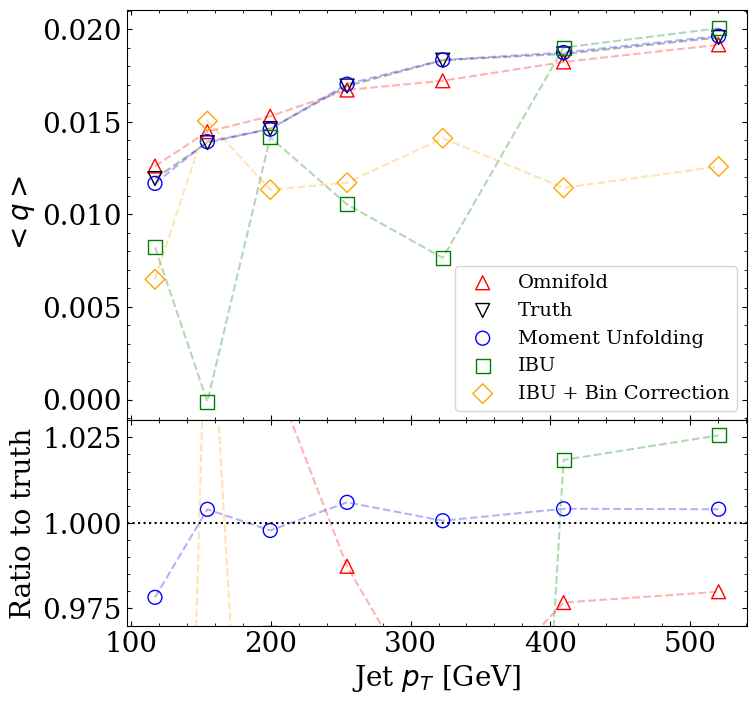

In [104]:
fig = plt.figure(figsize=(8, 8))
markersize = 100

gs = gridspec.GridSpec(2, 1, height_ratios=[4,2]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.set_xticklabels([])
ax0.tick_params(direction="in",which="both")
plt.yticks(fontsize=20)
ax0.minorticks_on()

ax0.scatter(binmid,means_unbinnedx,marker='^',label="Omnifold",edgecolors='red', facecolors='none', s = markersize)
ax0.plot(binmid,means_unbinnedx,ls = '--', c = 'r', alpha = 0.3)

ax0.scatter(binmid,truth,marker='v',label="Truth",edgecolors='black', facecolors='none', s = markersize)
ax0.plot(binmid,truth,ls = '--', c = 'black', alpha = 0.3)

ax0.scatter(binmid, weighted_gen, label="Moment Unfolding", marker = 'o', edgecolors = 'b', facecolors = 'none', s = markersize)
ax0.plot(binmid,weighted_gen,ls = '--', c = 'blue', alpha = 0.3)

ax0.scatter(binmid, means_binnedx, label = "IBU", marker = 's', edgecolors = 'green', facecolors='none', s = markersize)
ax0.plot(binmid,means_binnedx,ls = '--', c = 'green', alpha = 0.3)

ax0.scatter(binmid,means_binnedx_alt_corrected,label="IBU + Bin Correction", marker = 'D', edgecolor = 'orange', facecolor = 'none', s = markersize)
ax0.plot(binmid,means_binnedx_alt_corrected,ls = '--', c = 'orange', alpha = 0.3)

#plt.ylim([0.05,0.25])

plt.legend(frameon=True,fontsize=14)
if (moment==1):
    plt.ylabel(r'$< '+obs+' >$',fontsize=20)
else:
    plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$',fontsize=20)
if (obs=='m'):
    if (moment==1):
        plt.ylabel(r'$< '+obs+' >$ [GeV]',fontsize=20)
    else:
        plt.ylabel(r'$< '+obs+'^'+str(moment)+' >$ [GeV$^'+str(moment)+'$]',fontsize=20)
    
ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()

ax1.scatter(binmid,means_unbinnedx/truth,marker='^',label="Omnifold",edgecolors='red', facecolors='none', s = markersize)
ax1.plot(binmid,means_unbinnedx/truth,ls = '--', c = 'r', alpha = 0.3)
ax1.scatter(binmid, weighted_gen/truth, label="Moment Unfolding", marker = 'o', edgecolors = 'b', facecolors = 'none', s = markersize)
ax1.plot(binmid, weighted_gen/truth,ls = '--', c = 'b', alpha = 0.3)
ax1.scatter(binmid, means_binnedx/truth, label = "IBU", marker = 's', edgecolors = 'green', facecolors='none', s = markersize)
ax1.plot(binmid,means_binnedx/truth,ls = '--', c = 'green', alpha = 0.3)
ax1.scatter(binmid,means_binnedx_alt_corrected/truth,label="IBU + Bin Correction", marker = 'D', edgecolor = 'orange', facecolor = 'none', s = markersize)
ax1.plot(binmid,means_binnedx_alt_corrected/truth,ls = '--', c = 'orange', alpha = 0.3)

ax1.set_xlabel("Jet $p_{T}$ [GeV]",fontsize=20)
ax1.axhline(1.,ls=":",color="black")
ax1.set_ylim([0.97,1.03])
#ax1.legend(frameon=True,ncol=2,fontsize=14)
plt.ylabel('Ratio to truth',fontsize=20)

plt.subplots_adjust(wspace=0, hspace=0.0)

fig.savefig('figures/moment'+str(moment)+"_"+obs+'_v_pT.pdf',bbox_inches='tight')